# Experiment 1: Testing on sample data: Sinewave. 

Result: The model fits! 

TODO: 

- [ ] Extract the encoder. 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

from tcnAutoencoder import TCNAutoencoder

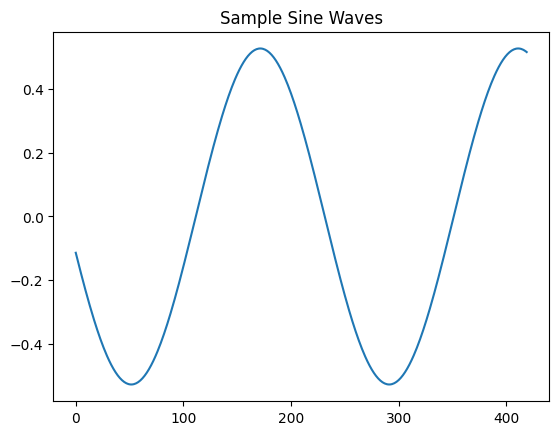

In [3]:

# Check if the model works with a sample sine wave

def generate_sine_wave_pairs(seq_length, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_length)
    data = []
    for _ in range(num_samples):
        intervals = np.random.uniform(1, 4, 2)
        amplitudes = np.random.uniform(0.1, 0.9, 2)
        offset = np.random.uniform(0, 2 * np.pi)
        sample1 = amplitudes[0] * np.sin((x + offset) * intervals[0])
        sample2 = amplitudes[1] * np.sin((x + offset) * intervals[1])
        data.append(np.array([sample1, sample2]))
    return np.array(data)
        

seq_length = 420  # Length of each sine wave sequence
num_samples = 36  # Number of samples

sine_data = generate_sine_wave_pairs(seq_length, num_samples)

# Plot a sample sine wave
plt.plot(np.flip(sine_data[0])[0])
plt.title('Sample Sine Waves')
plt.show()

In [4]:
# Create the dataset
import torch
from torch.utils.data import Dataset

class SineWaveDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = SineWaveDataset(sine_data)

# Create the dataloader
from torch.utils.data import DataLoader

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
model = TCNAutoencoder(input_dim=(seq_length, 2))

# Prefer CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
# Else, check if metal is available
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)

print(f"Running on {device}")

Running on mps


In [6]:
def train_model(model, dataloader, num_epochs=300, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        model.train()
        for data in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# train_model(model, dataloader)

# Experiment 2: Check if my model can work on arbitrary length data. 

In [44]:
model = TCNAutoencoder(input_dim=(71999, 2))


In [51]:
input = torch.randn(1, 2, 71999)

encoded = model.encoder(input)

encoded.shape

torch.Size([1, 4, 2057])

In [14]:
# %load load_data.py
import numpy as np
import pandas as pd
import glob, os, re


# Read the data only once.  It's big!
csv_files = glob.glob(os.path.join(".", "data", "hft_data", "*", "*_message_*.csv"))
date_str = re.compile(r'_(\d{4}-\d{2}-\d{2})_')
stock_str = re.compile(r'([A-Z]+)_\d{4}-\d{2}-\d{2}_')

df_list = []
day_list = []
sym_list = []

for csv_file in sorted(csv_files):
    date = date_str.search(csv_file)
    date = date.group(1)
    day_list.append(date)

    symbol = stock_str.search(csv_file)
    symbol = symbol.group(1)
    sym_list.append(symbol)

    # Find the order book file that matches this message file.
    book_file = csv_file.replace("message", "orderbook")

    # Read the message file and index by timestamp.
    df = pd.read_csv(csv_file, names=['Time','EventType','OrderID','Size','Price','Direction'])
    df['Time'] = pd.to_datetime(date) + pd.to_timedelta(df['Time'], unit='s')

    # Read the order book file and merge it with the messages.
    names = [f"{x}{i}" for i in range(1,11) for x in ["AP","AS","BP","BS"]]
    df = df.join(pd.read_csv(book_file, names=names), how='inner')
    df = df.set_index(['Time'])

    BBID_COL = df.columns.get_loc("BP1")
    BASK_COL = df.columns.get_loc("AP1")

    print (f"Read {df.shape[0]} unique order book shapshots from {csv_file}")

    df_list.append(df)

days = len(day_list)


Read 738034 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-01_34200000_57600000_message_10.csv
Read 1923409 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-04_34200000_57600000_message_10.csv
Read 2108353 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-05_34200000_57600000_message_10.csv
Read 2364167 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-06_34200000_57600000_message_10.csv
Read 1732063 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-07_34200000_57600000_message_10.csv
Read 3123866 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-08_34200000_57600000_message_10.csv


In [43]:
df = df_list[0]

df.head()

# extact things that I need: price, and size. 

df = df[['Price', 'Size']]
df.head()

# sample every 100ms, and the size would be the sum of the size in that 100ms. 
# Price would be the average price in that 100ms.
df = df.resample('100ms').agg({'Price': 'mean', 'Size': 'sum'})

# Check for NaN values

# forwardfill all NaN values in the data
df = df.fillna(method='ffill')

# normalize the data with mean and std
mean = df['Price'].mean()
std = df['Price'].std()
df['Price'] = (df['Price'] - mean) / std

mean = df['Size'].mean()
std = df['Size'].std()
df['Size'] = (df['Size'] - mean) / std

# histogram of the price, display the distribution plot only
df['Price'].plot.hist(bins=100)



/var/folders/g2/0bsk293n2pj2tsfkw7n824qw0000gp/T/ipykernel_79844/1375405758.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


(71999, 2)